<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/audiovisual_ELM_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [60]:
import numpy as np
from sklearn.svm import SVC # support vector classifier
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets.samples_generator import make_blobs
import torch 
import torch.nn as nn 

# Model Implementations

In [23]:
# SVM 
# we want to use an RBF kernel
# "optimization parameter of the SVM was set to 1 and the kernel parameter was 1.5"
svm_model = SVC(kernel='rbf', C=1) # How do i set a kernel parameter? 


In [55]:
# plot decision boundary 
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 50)
    y = np.linspace(ylim[0], ylim[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    print(X.shape, Y.shape, xy.shape)
    P = model.decision_function(xy)#.reshape(X.shape)
    print("P", P) # score for each class
    P_vals = np.argmax(P, axis=1)
    print("P vals", P_vals, "\len P", P.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P_vals, colors=['r', 'b', 'y', 'g'],
               levels=[0, 1, 2, 3], alpha=0.5,
               linestyles=['--', '-', '--', '-'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [8]:
def one_v_all_labels(y, label):
  # y is a vector of labels
  # label is an integer indicating the class of interest
  new_labs = np.where(y==label, 1, -1)
  return new_labs

## Test Code

In [10]:
# testing label change code
y = np.array([1, 2, 3, 4, 1, 1, 2, 3, 4, 4, 4])
label = 2
new_labs = one_v_all_labels(y, label)
print(new_labs)


[-1  1 -1 -1 -1 -1  1 -1 -1 -1 -1]


50 50


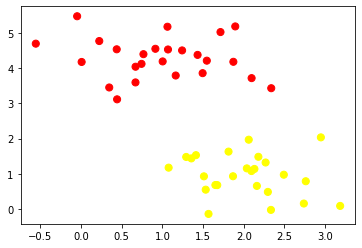

In [25]:
# Testing SVM 
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');
# so X is 50x2 input, y is 50x1
print(len(X), len(y)) # I think these are lists

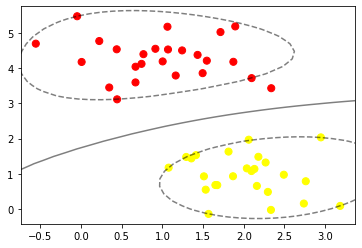

In [30]:
# fit model 
svm_model.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(svm_model);

[0 0 3 0 0 1 0 2 2 3 0 1 2 1 3 3 3 2 1 3 0 1 3 0 3 0 3 3 0 0 3 2 0 2 3 3 1
 3 0 2 2 2 0 1 2 2 2 3 1 1 2 3 3 3 0 2 1 0 2 1 1 1 1 2 3 3 0 2 2 0 1 1 1 0
 0 0 2 1 1 2 0 1 3 2 0 1 3 0 0 1 1 2 2 3 2 2 1 0 1 1 1 1 3 3 1 1 1 2 1 1 2
 0 3 0 0 0 2 3 0 2 3 1 0 0 0 3 3 3 0 2 2 2 1 2 3 2 2 2 1 3 3 0 3 1 3 0 0 2
 1 3]


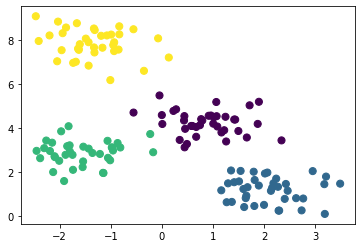

In [40]:
X_multi, y_multi = make_blobs(n_samples=150, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, s=50) #, cmap='autumn');
# so X is 50x2 input, y is 50x1
X_multi = np.array(X_multi)
y_multi = np.array(y_multi)
print(y_multi)

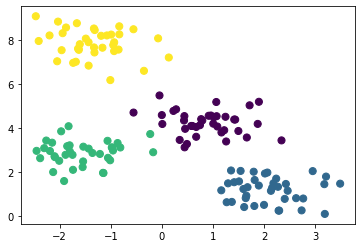

In [57]:
# THIS IS THE LITERAL ONLY IMPORTANT LINE!!! vvv
clf = OneVsRestClassifier(SVC(kernel='rbf', C=1))
clf.fit(X_multi, y_multi)
plt.scatter(X_multi[:, 0], X_multi[:, 1], c=y_multi, s=50) #, cmap='autumn')
#plot_svc_decision_function(clf);

# ELMs

In [61]:
cuda_avail = torch.cuda.is_available()
# Input to first ELM:
# input size will be the concatenated length of the output of the two CNNs
class ELM():
  def __init__(self, input_size, hidden_size, num_classes, device=None):
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = num_classes # 2 for first ELM, 5 for second
    self.device = device

    # just two layers; declare parameters: (maybe use xavier_uniform inits?) 
    self.alpha = nn.init.uniform_(torch.empty(self.input_size, self.hidden_size, device=self.device), a=-1., b=1.)
    self.beta = nn.init.uniform_(torch.empty(self.hidden_size, self.output_size, device=self.device), a=-1., b=1.)

    self.bias = torch.zeros(self.hidden_size, device=self.device)

    self.activation = torch.nn.functional.gelu() # other activations? # they said 'gaussian kernel'

  def forward(self, x):
    h = self.activation(torch.add(x.mm(self.alpha), self.bias)) # forward used for training
    return x.mm(beta)
    #return h

  def forwardToHidden(self, x):  # the output of this is what we feed to the next ELM AFTER THIS ONE IS TRAINED
    return self.activation(torch.add(x.mm(self.alpha), self.bias))

In [ ]:
# Steps:
'''
1) Train first model
2) Get outputs of first model
3) train second model on hidden layer output of first model
4) pass hidden layer output of second model to SVM
'''
model = ELM(in_size, 100, 2)
if cuda_avail:
  model.cuda()
optimizer = pseudoInverse(params=model.parameters(), C=0.001, L=0)
def train_ELM(model, optimizer, train_loader):
  model.train()
  correct=0
  for batch_idx, (data, target) in enumerate(train_loader):
    if cuda_avail:
      data, target = data.cuda(), taget.cuda() # .device() 
    data, target = Variable(data, requires_grad = False, volatile=True),  Variable(target, requires_grad = False, volatile=True)
    hiddenOut = model.forwardToHidden(data)
    optimizer.train(inputs=hiddenOut, targets=target)
    output=model.forward(data)
    pred=output.data.max(1)[1]
    correct+=pred.eq(target.data).cpu().sum()
  print('Accuracy:{}/{} ({:.2f}%)\n'.format(
        correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
  
def test(model,test_loader):
    model.train()
    correct = 0
    for data, target in test_loader:
        if cuda_avail:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data,requires_grad=False, volatile=True), Variable(target,requires_grad=False, volatile=True)
        output = model.forward(data)
        pred=output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()
    print('\nTest set accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
train(args,model,optimizer,train_loader)
test(args,model,test_loader)